In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import CartesianRepresentation, UnitSphericalRepresentation
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product

In [610]:
from rms import Star, Planet, STSP, Spot

In [1416]:
from scipy.integrate import quad 

def limb_darkening(u_ld, r):
    u1, u2 = u_ld
    mu = np.sqrt(1 - r**2)
    return (1 - u1 * (1 - mu) - u2 * (1 - mu)**2) / (1 - u1/3 - u2/6) / np.pi

def limb_darkening_normed(u_ld, r): 
    return limb_darkening(u_ld, r)/limb_darkening(u_ld, 0)

def total_flux(u_ld): 
    return 2 * np.pi * quad(lambda r: r * limb_darkening_normed(u_ld, r), 0, 1)[0]

spot_contrast = 0.7
u_ld = [0.5079, 0.2239]
f0 = total_flux(u_ld)

In [1473]:
n_rotations = 1000
# angles = np.ones(n_rotations) * 180*u.deg
angles = np.arange(0, 2*np.pi, 2*np.pi/n_rotations) * u.rad

In [1648]:
n_incs = 1
n_spots = 2

p = 0.05
spot_contrast = 0.7
b = 0
a_rs = 15

inc_stellar = np.array([90]) * u.deg
spot_radii = np.array([[0.05], [0.05]])
spot_lats = np.array([[0], [0]]) * u.deg 
# spot_lons = np.array([[150], [210]]) * u.deg
spot_lons = np.array([[160], [200]]) * u.deg

#d = np.linspace(-15, 15, n_rotations)
d = np.linspace(-a_rs, a_rs, n_rotations)
z = np.abs(d)

***

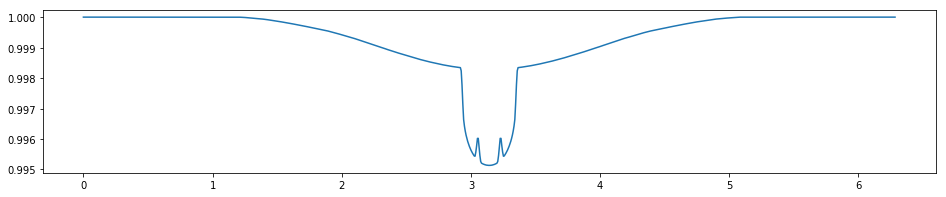

In [1649]:
from astropy.time import Time

times = Time(np.linspace(0, 2*np.pi, n_rotations), format='jd')
planet = Planet(per=2*np.pi, inc=90, a=a_rs, t0=np.pi, rp=p, ecc=0, w=90, lam=0, b=0)
star = Star(planet, rotation_period=2*np.pi, inc_stellar=90, spot_contrast=spot_contrast, u=u_ld, rho_s=0.038)
stsp_spots = [Spot(spot_lats[0, 0], spot_lons[0, 0] + 180 * u.deg, spot_radii[0, 0]), 
              Spot(spot_lats[1, 0], spot_lons[1, 0] - 180 * u.deg , spot_radii[1, 0])]

with STSP(times, star, stsp_spots) as s: 
    lc = s.generate_lightcurve(normalize_oot=False)
    
fig, ax = plt.subplots(figsize=(16, 3))
plt.plot(lc.times.jd, lc.fluxes)

***

$$ \lambda ^ { e } ( p , z ) = \left\{ \begin{array} { l l } { 0 , } & { 1 + p < z } \\ { \frac { 1 } { \pi } \left[ p ^ { 2 } \kappa _ { 0 } + \kappa _ { 1 } - \sqrt { \frac { 4 z ^ { 2 } - \left( 1 + z ^ { 2 } - p ^ { 2 } \right) ^ { 2 } } { 4 } } \right] , } & { | 1 - p | < z \leq 1 + p } \\ { p ^ { 2 } , } & { z \leq 1 - p } \\ { 1 , } & { z \leq p - 1 } \end{array} \right. $$

where

$$ \kappa _ { 0 } = \cos ^ { - 1 } \left[ \left( p ^ { 2 } + z ^ { 2 } - 1 \right) / 2 p z \right], \kappa _ { 1 } = \cos ^ { - 1 } \left[ \left( 1 - p ^ { 2 } + z ^ { 2 } \right) / 2 z \right]  $$

$$    \lambda^e_{\rm max} = \left(\frac{R_p}{R_\star}\right)^2 \frac{1-u_1(1-\sqrt{1-b^2})-u_2 (1-\sqrt{1-b^2})^2}{1-\tfrac{u_1}{3}-\tfrac{u_2}{6}},$$

In [1650]:
from shapely.geometry.point import Point
from shapely import affinity
from matplotlib.patches import Polygon
import numpy as np

def create_ellipse(center, lengths, angle=0):
    """
    create a shapely ellipse. adapted from
    https://gis.stackexchange.com/a/243462
    """
    ellr = affinity.rotate(affinity.scale(Point(center).buffer(1), lengths[0], lengths[1]), angle)
    return ellr

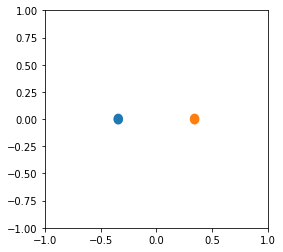

In [1651]:

from matplotlib.collections import PatchCollection

usr = UnitSphericalRepresentation(spot_lons, spot_lats) 
cartesian = usr.represent_as(CartesianRepresentation)
rotate = rotation_matrix(angles[:, np.newaxis, np.newaxis], axis='z')
tilt = rotation_matrix(inc_stellar - 90*u.deg, axis='y')
rotated_spot_positions = cartesian.transform(rotate)
tilted_spot_positions = rotated_spot_positions.transform(tilt)

r = np.ma.masked_array(np.hypot(tilted_spot_positions.y.value, 
                                tilted_spot_positions.z.value), 
                       mask=tilted_spot_positions.x.value < 0)
ld = limb_darkening_normed(u_ld, r)

def occult(z, p): 
    lambda_e = np.zeros_like(z)
    ingress_egress = (np.abs(1-p) < z) & (z <= 1 + p)
    bottom = (z <= 1 - p)
    full = (z <= p - 1)
    kappa_0 = np.arccos((p**2 + z[ingress_egress]**2 - 1) / 
                        (2*p*z[ingress_egress]))
    kappa_1 = np.arccos((1 - p**2 + z[ingress_egress]**2) / 
                        (2*z[ingress_egress]))
    lambda_e[ingress_egress] = (p**2 * kappa_0 + kappa_1 - 
                                np.sqrt((4*z[ingress_egress]**2 - 
                                        (1+z[ingress_egress]**2-p**2)**2)/4))/np.pi
    lambda_e[bottom] = p**2
    lambda_e[full] = 1

    return lambda_e

mu = np.zeros_like(z)
mu[z <= 1] = np.sqrt(1 - z[z <= 1]**2)
ld_factor = (1 - u_ld[0] * (1 - mu) - u_ld[1] * (1 - mu)**2 ) / (1 - u_ld[0]/3 - u_ld[1]/6)
lambda_e = occult(z, p) * ld_factor

spots = []
plot_ellipses = True

if plot_ellipses: 
    fig, ax = plt.subplots(figsize=(4,4))

mid_transit_time = int(n_rotations/2)
ax.set(xlim=[-1, 1], ylim=[-1, 1])
planet = [create_ellipse([d[i], 0], [p, p]) for i in range(len(d))]

for i in range(n_spots):
        if tilted_spot_positions.x.value[mid_transit_time, i, 0] > 0:

            angle = np.arctan2(tilted_spot_positions.z.value[mid_transit_time, i, 0], 
                               tilted_spot_positions.y.value[mid_transit_time, i, 0])

            ellipse = create_ellipse([tilted_spot_positions.y.value[mid_transit_time, i, 0], 
                                      tilted_spot_positions.z.value[mid_transit_time, i, 0]], 
                                     [spot_radii[i, 0]*np.sqrt(1 - r_spot**2), 
                                      spot_radii[i, 0]], np.degrees(angle))
            spots.append(ellipse)

            if plot_ellipses:
                x, y = ellipse.exterior.coords.xy
                ax.fill(x, y)

intersections = np.sum([[planet[i].intersection(spots[j]).area / p**2 / np.pi
                         for i in range(len(planet))] 
                        for j in range(len(spots))], axis=0)
lambda_e -= p**2 * (1 - spot_contrast) * intersections

f_spots = np.pi * spot_radii**2 * (1 - spot_contrast) * ld * np.sqrt(1 - r**2)

delta_f = (1 - np.sum(f_spots.filled(0)/f0, axis=1)[:, 0] - lambda_e)

(2.5, 3.8)

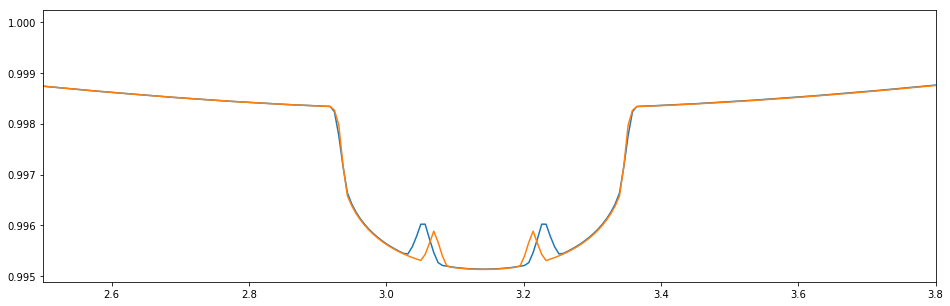

In [1654]:
plt.figure(figsize=(16, 5))
plt.plot(lc.times.jd, lc.fluxes)
plt.plot(lc.times.jd, delta_f)
# plt.axhline(1 - p**2, ls='--')
# plt.xlim([4500, 5500])
# plt.ylim([0.969, 0.975])
plt.xlim([2.5, 3.8])
# plt.ylim([0.99, 0.998])
# plt.ylim([0.98, 0.9925])

In [1450]:


ellipse1 = create_ellipse((0,0),(2,4),10)
ellipse2 = create_ellipse((1,-1),(3,2),50)

intersect = ellipse1.intersection(ellipse2)

print('area of intersect:',intersect.area)

plt.show()

area of intersect: 13.656608779925698


In [1449]:
%timeit ellipse1.intersection(ellipse2)

234 µs ± 11.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
